In [3]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import numpy as np
from sklearn.cluster import KMeans
from sklearn import preprocessing, cross_validation, neighbors, svm, linear_model
from sklearn.ensemble import RandomForestRegressor

import pandas as pd



In [4]:
df = pd.read_csv('autos.csv', encoding='cp1252')

#this gives the columns to be dropped with mean etc close to  -- nrOfPictures
print(df.describe())



              price  yearOfRegistration        powerPS      kilometer  \
count  3.715280e+05       371528.000000  371528.000000  371528.000000   
mean   1.729514e+04         2004.577997     115.549477  125618.688228   
std    3.587954e+06           92.866598     192.139578   40112.337051   
min    0.000000e+00         1000.000000       0.000000    5000.000000   
25%    1.150000e+03         1999.000000      70.000000  125000.000000   
50%    2.950000e+03         2003.000000     105.000000  150000.000000   
75%    7.200000e+03         2008.000000     150.000000  150000.000000   
max    2.147484e+09         9999.000000   20000.000000  150000.000000   

       monthOfRegistration  nrOfPictures    postalCode  
count        371528.000000      371528.0  371528.00000  
mean              5.734445           0.0   50820.66764  
std               3.712412           0.0   25799.08247  
min               0.000000           0.0    1067.00000  
25%               3.000000           0.0   30459.00000  


In [5]:
print(df.isnull().sum())
#This shows how many entries are null and what should we do with them

dateCrawled                0
name                       0
seller                     0
offerType                  0
price                      0
abtest                     0
vehicleType            37869
yearOfRegistration         0
gearbox                20209
powerPS                    0
model                  20484
kilometer                  0
monthOfRegistration        0
fuelType               33386
brand                      0
notRepairedDamage      72060
dateCreated                0
nrOfPictures               0
postalCode                 0
lastSeen                   0
dtype: int64


In [6]:
print(df.seller.unique())

['privat' 'gewerblich']


In [7]:
print(df.groupby('seller').size())

seller
gewerblich         3
privat        371525
dtype: int64


In [8]:
print(df.offerType.unique())

['Angebot' 'Gesuch']


In [9]:
print(df.abtest.unique())

['test' 'control']


In [10]:
print(df.groupby('offerType').size())

offerType
Angebot    371516
Gesuch         12
dtype: int64


In [11]:
#Drop any columns with too many unique values or too less values - seller, offerType, nrOfPictures
df.drop(['seller', 'offerType', 'abtest', 'nrOfPictures', 'dateCreated'], axis='columns', inplace=True)

In [12]:
print("Too new: %d" % df.loc[df.yearOfRegistration >= 2017].count()['name'])
print("Too old: %d" % df.loc[df.yearOfRegistration < 1950].count()['name'])
print("Too cheap: %d" % df.loc[df.price < 100].count()['name'])
print("Too expensive: " , df.loc[df.price > 150000].count()['name'])
print("Too few km: " , df.loc[df.kilometer < 5000].count()['name'])
print("Too many km: " , df.loc[df.kilometer > 200000].count()['name'])
print("Too few PS: " , df.loc[df.powerPS < 10].count()['name'])
print("Too many PS: " , df.loc[df.powerPS > 500].count()['name'])
print("Fuel types: " , df['fuelType'].unique())

print("Damages: " , df['notRepairedDamage'].unique())
#print("Postale codes: " , df['postalCode'].unique())
print("Vehicle types: " , df['vehicleType'].unique())
print("Brands: " , df['brand'].unique())

# Cleaning data
#valid_models = df.dropna()

#### Removing the duplicates
dedups = df.drop_duplicates(['name','price','vehicleType','yearOfRegistration'
                         ,'gearbox','powerPS','model','kilometer','monthOfRegistration','fuelType'
                         ,'notRepairedDamage'])

#### Removing the outliers
dedups = dedups[
        (dedups.yearOfRegistration <= 2016) 
      & (dedups.yearOfRegistration >= 1950) 
      & (dedups.price >= 100) 
      & (dedups.powerPS >= 10)  #can remove extra as well based on above calculations
      ]

Too new: 14680
Too old: 289
Too cheap: 13320
Too expensive:  232
Too few km:  0
Too many km:  0
Too few PS:  41040
Too many PS:  835
Fuel types:  ['benzin' 'diesel' nan 'lpg' 'andere' 'hybrid' 'cng' 'elektro']
Damages:  [nan 'ja' 'nein']
Vehicle types:  [nan 'coupe' 'suv' 'kleinwagen' 'limousine' 'cabrio' 'bus' 'kombi' 'andere']
Brands:  ['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda' 'nissan'
 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat' 'mini'
 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'porsche' 'toyota' 'chevrolet'
 'dacia' 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'rover'
 'land_rover' 'lada']


In [13]:
print(100*dedups['name'].count()/df['name'].count())
#82% of the original datset is left to be analysed

82.1006761267


In [14]:
dedups.isnull().sum()
#Now replace na values by what you think is the best replacement

dateCrawled                0
name                       0
price                      0
vehicleType            10855
yearOfRegistration         0
gearbox                 5302
powerPS                    0
model                  11480
kilometer                  0
monthOfRegistration        0
fuelType               15494
brand                      0
notRepairedDamage      42281
postalCode                 0
lastSeen                   0
dtype: int64

In [15]:
dedups['notRepairedDamage'].fillna(value='not-declared', inplace=True)
dedups['fuelType'].fillna(value='not-declared', inplace=True)
dedups['gearbox'].fillna(value='not-declared', inplace=True)
dedups['vehicleType'].fillna(value='not-declared', inplace=True)
dedups['model'].fillna(value='not-declared', inplace=True)

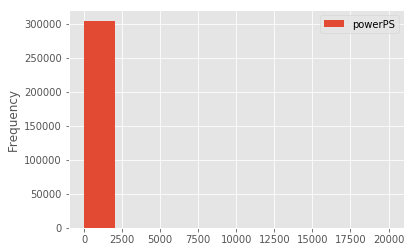

In [16]:
%matplotlib inline
dedups.plot(y='powerPS', kind='hist')
#Change the x axis to get better results

In [17]:
#cars_updated = dedups.apply(preprocessing.LabelEncoder().fit_transform)
dedups.head()

,dateCrawled,name,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,postalCode,lastSeen
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,18300,coupe,2011,manuell,190,not-declared,125000,5,diesel,audi,ja,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",9800,suv,2004,automatik,163,grand,125000,8,diesel,jeep,not-declared,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,1500,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,3600,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,650,limousine,1995,manuell,102,3er,150000,10,benzin,bmw,ja,33775,2016-04-06 19:17:07


In [18]:
#Using lastseen and yearOfRegisteration, create a column age (covert last Seen to python time, extract year, subtract yearOfRegisteration)
ageCol=[]
from dateutil import parser

for date in dedups['lastSeen']:
    temp=parser.parse(date)
    ageCol.append(temp.year)

dedups['ageCol']=ageCol-dedups['yearOfRegistration']

dedups['ageCol'].describe()

#Drop with age  <  0 and more than 50,
dedups=dedups[(dedups['ageCol']>1)&(dedups['ageCol']<50)]

In [19]:
dedups.head()

,dateCrawled,name,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,postalCode,lastSeen,ageCol
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,18300,coupe,2011,manuell,190,not-declared,125000,5,diesel,audi,ja,66954,2016-04-07 01:46:50,5
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",9800,suv,2004,automatik,163,grand,125000,8,diesel,jeep,not-declared,90480,2016-04-05 12:47:46,12
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,1500,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,91074,2016-03-17 17:40:17,15
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,3600,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,60437,2016-04-06 10:17:21,8
5,2016-04-04 17:36:23,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,650,limousine,1995,manuell,102,3er,150000,10,benzin,bmw,ja,33775,2016-04-06 19:17:07,21


In [20]:
dedups.head()

,dateCrawled,name,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,postalCode,lastSeen,ageCol
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,18300,coupe,2011,manuell,190,not-declared,125000,5,diesel,audi,ja,66954,2016-04-07 01:46:50,5
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",9800,suv,2004,automatik,163,grand,125000,8,diesel,jeep,not-declared,90480,2016-04-05 12:47:46,12
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,1500,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,91074,2016-03-17 17:40:17,15
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,3600,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,60437,2016-04-06 10:17:21,8
5,2016-04-04 17:36:23,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,650,limousine,1995,manuell,102,3er,150000,10,benzin,bmw,ja,33775,2016-04-06 19:17:07,21


In [21]:
#label encoder
z=dedups['price']

for cols in dedups.columns:
    dedups[cols]=preprocessing.LabelEncoder().fit_transform(dedups[cols])

dedups.describe()

,dateCrawled,name,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,postalCode,lastSeen,ageCol
count,295243.000000,295243.000000,295243.000000,295243.000000,295243.000000,295243.000000,295243.000000,295243.000000,295243.000000,295243.000000,295243.000000,295243.000000,295243.000000,295243.000000,295243.000000,295243.000000
mean,118428.275776,91331.463442,1415.529764,4.488313,35.845084,0.794898,116.923825,101.758958,10.548477,6.035334,1.962451,20.434208,1.040577,3687.466484,101230.752042,11.154916
std,68303.166164,53135.899081,1062.976988,1.791465,6.269060,0.441944,62.411300,71.287882,2.665597,3.563040,1.511016,13.432752,0.474279,2019.630095,46378.311537,6.269060
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,59224.500000,45284.000000,545.000000,4.000000,32.000000,1.000000,70.000000,40.000000,10.000000,3.000000,1.000000,9.000000,1.000000,2192.000000,62873.500000,7.000000
50%,118587.000000,90481.000000,1147.000000,5.000000,36.000000,1.000000,106.000000,99.000000,12.000000,6.000000,1.000000,23.000000,1.000000,3494.000000,124216.000000,11.000000
75%,177680.500000,136943.000000,2098.000000,6.000000,40.000000,1.000000,140.000000,162.000000,12.000000,9.000000,3.000000,33.000000,1.000000,5056.000000,139865.000000,15.000000
max,236218.000000,182651.000000,5122.000000,8.000000,47.000000,2.000000,732.000000,249.000000,12.000000,12.000000,7.000000,39.000000,2.000000,8114.000000,150084.000000,47.000000


In [22]:
X=dedups.drop(['price'],1)

col=dedups.columns

X1=preprocessing.scale(X)

In [23]:
X_train, X_test, Z_train, Z_test=cross_validation.train_test_split(X1,z,test_size=.2)

In [24]:
# apply linear regressor
model_sklearn=linear_model.LinearRegression()
model_sklearn.fit(X_train,Z_train)
model_sklearn.score(X_test,Z_test)

0.66065189573973693

In [25]:
#apply random forest
rf=RandomForestRegressor()
rf.fit(X_train,Z_train)

rf.score(X_test,Z_test)

0.90811280138397865

In [26]:
#Drop some more unimportant features.  drop monthOfRegisteration, postalCode

In [27]:
dedups=dedups.drop(['lastSeen','monthOfRegistration','dateCrawled','name','postalCode'],1)

In [28]:
#Run again

In [29]:
X=dedups.drop(['price'],1)

col=dedups.columns

X1=preprocessing.scale(X)
X_train, X_test, Z_train, Z_test=cross_validation.train_test_split(X1,z,test_size=.2)
rf.fit(X_train,Z_train)

rf.score(X_test,Z_test)

0.90617502024629459

In [30]:
#Find best features using RFE selector or RandomForest selector, use only those to see accuracy now.
print(rf.feature_importances_)
print(col)

[ 0.0335131   0.28651871  0.00527338  0.26148003  0.0266633   0.02375324
  0.00616978  0.03284225  0.01592998  0.30785622]
Index(['price', 'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS',
       'model', 'kilometer', 'fuelType', 'brand', 'notRepairedDamage',
       'ageCol'],
      dtype='object')


In [31]:
from sklearn.feature_selection import RFE
selector = RFE(rf, 7, step=1)
selector = selector.fit(X_train, Z_train)
selector.support_ 

array([ True,  True, False,  True,  True,  True, False,  True, False,  True], dtype=bool)

In [32]:
selector.ranking_

array([1, 1, 4, 1, 1, 1, 3, 1, 2, 1])

In [33]:
X.head()

,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,ageCol
1,3,44,1,180,162,11,3,1,0,3
2,8,37,0,153,118,11,3,14,2,10
3,4,34,1,65,117,12,1,38,1,13
4,4,41,1,59,102,9,3,31,1,6
5,6,28,1,92,11,12,1,2,0,19


In [34]:
X=dedups[['vehicleType','yearOfRegistration','powerPS','model','kilometer','brand','ageCol']]


In [35]:
X.head()

,vehicleType,yearOfRegistration,powerPS,model,kilometer,brand,ageCol
1,3,44,180,162,11,1,3
2,8,37,153,118,11,14,10
3,4,34,65,117,12,38,13
4,4,41,59,102,9,31,6
5,6,28,92,11,12,2,19


In [36]:
col=dedups.columns

X1=preprocessing.scale(X)
X_train, X_test, Z_train, Z_test=cross_validation.train_test_split(X1,z,test_size=.2)
rf.fit(X_train,Z_train)
#no fall in score
rf.score(X_test,Z_test)

0.89748565135839709

In [37]:
import seaborn as sns
def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,ageCol
price,1.000000,0.002539,0.585142,-0.324791,0.584823,-0.022703,-0.417055,0.101265,-0.128459,0.014504,-0.585142
vehicleType,0.002539,1.000000,0.002849,-0.106058,0.120888,-0.146510,0.038787,0.061937,-0.111259,0.013928,-0.002849
yearOfRegistration,0.585142,0.002849,1.000000,-0.114154,0.204485,0.036086,-0.337254,0.108331,-0.054313,-0.037573,-1.000000
gearbox,-0.324791,-0.106058,-0.114154,1.000000,-0.432371,0.047687,0.024568,-0.066823,0.125323,0.034082,0.114154
powerPS,0.584823,0.120888,0.204485,-0.432371,1.000000,-0.127254,-0.012088,0.095142,-0.298663,-0.015633,-0.204485
model,-0.022703,-0.146510,0.036086,0.047687,-0.127254,1.000000,-0.020525,0.046230,0.474290,0.016095,-0.036086
kilometer,-0.417055,0.038787,-0.337254,0.024568,-0.012088,-0.020525,1.000000,0.102186,-0.029201,-0.002386,0.337254
fuelType,0.101265,0.061937,0.108331,-0.066823,0.095142,0.046230,0.102186,1.000000,-0.027156,0.056530,-0.108331
brand,-0.128459,-0.111259,-0.054313,0.125323,-0.298663,0.474290,-0.029201,-0.027156,1.000000,0.013941,0.054313
notRepairedDamage,0.014504,0.013928,-0.037573,0.034082,-0.015633,0.016095,-0.002386,0.056530,0.013941,1.000000,0.037573


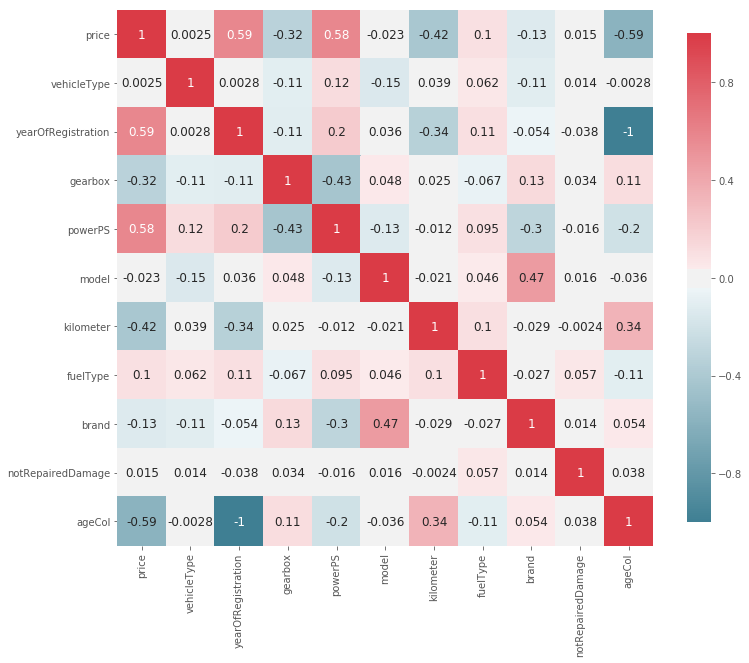

In [38]:
plot_correlation_map(dedups)
dedups.corr()

In [39]:
plt.show()
#see that yearOfRegistration and ageCol